# Uber Vs Lyft - Which Service Is Better?

### Understanding the quality of Rideshare Apps, Uber & Lyft, based on factors such as distance traveled, pricing and weather conditions in Winter 2018, Boston (MA)

In [159]:
# Importing dependencies required for our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [160]:
# Referencing our csv files to prep for merging
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

## Part 1 - Cleaning our data
----
#### Our Cab Ride data contains a list of rides taken between a range of sources and destinations, along with their prices, surge multipliers and ride type (example - Uber Pool or Uber XL). Our Weather data gives us a selection of weather conditions measure against a series of similar timestamps.

In [161]:
# Cleaning Weather Data
# The timestamps are listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-12-16 23:45:01,Back Bay,42.42,1.0,1012.14,0.1228,0.77,11.25
1,2018-12-16 23:45:01,Beacon Hill,42.43,1.0,1012.15,0.1846,0.76,11.32
2,2018-12-16 23:45:01,Boston University,42.50,1.0,1012.15,0.1089,0.76,11.07
3,2018-12-16 23:45:01,Fenway,42.11,1.0,1012.13,0.0969,0.77,11.09
4,2018-12-16 23:45:01,Financial District,43.13,1.0,1012.14,0.1786,0.75,11.49


In [162]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-12-16 09:30:07.890000128,Haymarket Square,North Station,0.44,5.0,1.0,Lyft,Shared
1,2018-11-27 02:00:23.676999936,Haymarket Square,North Station,0.44,11.0,1.0,Lyft,Lux
2,2018-11-28 01:00:22.197999872,Haymarket Square,North Station,0.44,7.0,1.0,Lyft,Lyft
3,2018-11-30 04:53:02.749000192,Haymarket Square,North Station,0.44,26.0,1.0,Lyft,Lux Black XL
4,2018-11-29 03:49:20.223000064,Haymarket Square,North Station,0.44,9.0,1.0,Lyft,Lyft XL


In [163]:
# Merge the datesets into a single one based on time_stamp and location
# Our timestamps vary across our weather and car ride data, so on rows where we don't have an exact match, we want to merge weather conditions at an approximated timestamp of 15 minutes
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ))
cleaned_merged_df.head()



,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,NaN,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,NaN,1.0,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,NaN,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36


In [164]:
# Do we want to convert date timestamps to H:M:S format here, before proceeding?

In [165]:
# Taking a look at our cleaned and merged dataframe as a whole to identify any obvious data points
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [166]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36


In [167]:
# Adding the day of the week and month to our table to see if that may have any correlation to weather or pricing
final_df["day_of_week"]=final_df["date"].dt.day_name()

final_df["month"] = final_df["date"].dt.month

final_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week,month
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday,11
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday,11
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday,11


In [168]:
# Formatting some columns to show accurate values for percentages

final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [169]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday", "month":"Month","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)"})

final_df = final_df[["Date","Weekday","Month","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

,Date,Weekday,Month,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph)
0,2018-11-26 03:40:46.318000128,Monday,11,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36
1,2018-11-26 03:40:46.319000064,Monday,11,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:46.319000064,Monday,11,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60
3,2018-11-26 03:40:46.320000000,Monday,11,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:46.320000000,Monday,11,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36


In [170]:
# Finding the size of our final dataframe
final_df.shape

(251827, 16)

In [171]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

## Part 2 - Understanding our Dataset
----
#### With a large set of data, we want to begin by understanding the general marketability of Uber vs Lyft, like what's the general preference of rides or who makes more money. This is our first step before diving into more deeper analyses

2.A. What is the overall percentages of rides taken over the given timeframe?

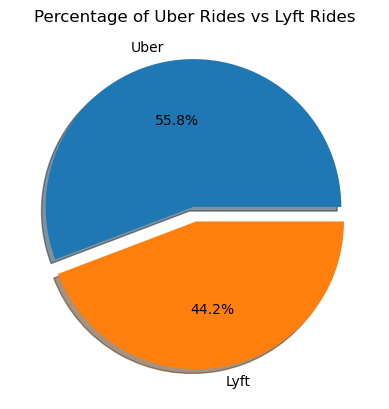

In [172]:
# Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()
percentages = (ride_counts / ride_counts.sum()) * 100

explode = [0.05] * len(percentages)

plt.pie(percentages, labels=percentages.index, explode=explode, shadow=True, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.show()

2.B How many rides were taken depending on distance travelled? Do people use Lyft or Uber more for longer distances?

In [173]:
# Find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


In [174]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
uber_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Uber Ride Count":ride_counts})
uber_ranges

,Distance Range,Uber Ride Count
0,0-2 miles,67317
1,2-4 miles,63131
2,4-6 miles,8679
3,6-8 miles,1339


In [175]:
# Filter the DataFrame to include only Lyft rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Lyft rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
lyft_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Lyft Ride Count":ride_counts})
lyft_ranges

,Distance Range,Lyft Ride Count
0,0-2 miles,51883
1,2-4 miles,51591
2,4-6 miles,7865
3,6-8 miles,22


In [176]:
# Merge data into a single table for easy plotting
range_df=pd.merge(uber_ranges,lyft_ranges, on="Distance Range", how="left")
range_df

,Distance Range,Uber Ride Count,Lyft Ride Count
0,0-2 miles,67317,51883
1,2-4 miles,63131,51591
2,4-6 miles,8679,7865
3,6-8 miles,1339,22


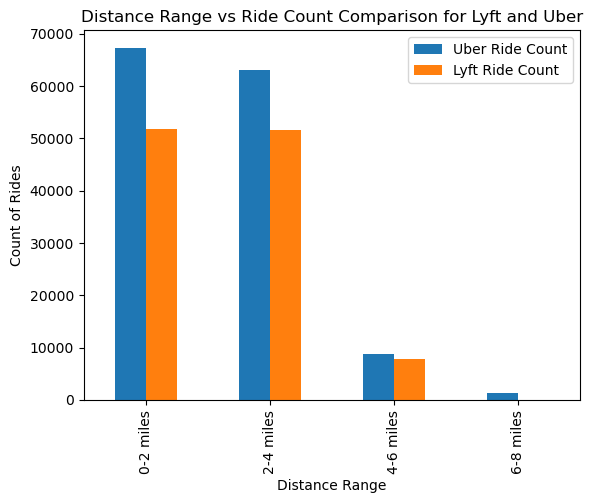

In [177]:
# Plotting a bar chart to show rides taken for various distance ranges per rideshare app
ax=range_df.plot.bar()
labels=range_df["Distance Range"]
ax.set_xticklabels(labels)
plt.title("Distance Range vs Ride Count Comparison for Lyft and Uber")
plt.xlabel("Distance Range")
plt.ylabel("Count of Rides")
plt.show()

2.C Knowing the number of rides taken for each rideshare app, how does this translate into overall revenue earned by Uber vs Lyft?

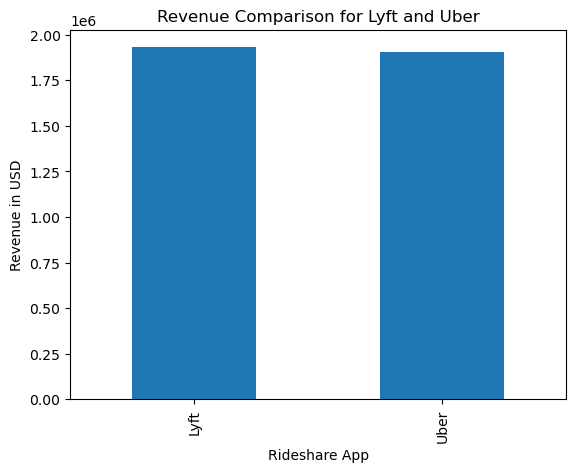

In [178]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()

#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()


In [179]:
# For a deeper dive, let's look at revenue per month for each rideshare app
lyft=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby("Month")["Price($)"].sum()

uber=final_df[final_df["Rideshare_App"]=="Uber"]
uber_monthly_rev=uber.groupby(["Month"])["Price($)"].sum()

# Create a Dataframe to show revenue based on each rideshare app
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})
monthly_rev_df

,Lyft,Uber
Month,,
11,1126795.80,1117151.5
12,803659.35,785612.5


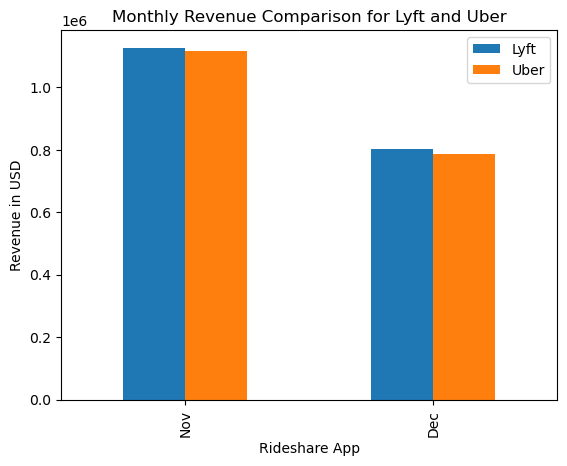

In [180]:
# Plotting a bar chart to show revenue based on month, per rideshare app
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

2.D At what time do people prefer to take an Uber vs. Lyft? Is there a behavioral trend that differentiates how people use these apps?

In [181]:
# In order to look at the number of rides taken per hour, we need to extract the information from the timestamps

final_df["Hour"]=final_df["Date"].dt.hour
final_df.head()

,Date,Weekday,Month,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph),Hour
0,2018-11-26 03:40:46.318000128,Monday,11,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36,3
1,2018-11-26 03:40:46.319000064,Monday,11,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55,3
2,2018-11-26 03:40:46.319000064,Monday,11,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60,3
3,2018-11-26 03:40:46.320000000,Monday,11,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55,3
4,2018-11-26 03:40:46.320000000,Monday,11,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36,3


In [182]:
# Let's find average number of Uber Rides taken per day and per hour

uber=final_df.loc[final_df["Rideshare_App"]=="Uber"]

grouped_hour_day = uber.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_uber = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_uber)

Hour  Weekday  
0     Friday        516.0
      Monday        644.0
      Saturday      475.0
      Sunday        501.0
      Thursday     2336.0
                    ...  
23    Saturday      529.0
      Sunday        844.0
      Thursday      489.0
      Tuesday       828.0
      Wednesday    2345.0
Length: 163, dtype: float64


In [183]:
# Let's find average number of Lyft Rides taken per day and per hour

lyft=final_df.loc[final_df["Rideshare_App"]=="Lyft"]

grouped_hour_day = lyft.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_lyft = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_lyft)

Hour  Weekday  
0     Friday        420.0
      Monday        436.0
      Saturday      461.0
      Sunday        435.0
      Thursday     1879.0
                    ...  
23    Saturday      407.0
      Sunday        681.0
      Thursday      447.0
      Tuesday       732.0
      Wednesday    1711.0
Length: 163, dtype: float64


In [184]:
# Defining a function that'll allow us to easily plot some timeseries graphs

def plot(dataframe):
# Create a list of weekdays to use as labels
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a figure and axis objects
    fig, ax = plt.subplots(figsize=(10,6))

# Iterate over each weekday and plot a line for the count of car rides
    for weekday in weekdays:
        data = dataframe.loc[dataframe.index.get_level_values('Weekday') == weekday]
        ax.plot(data.index.get_level_values('Hour'), data, label=weekday)


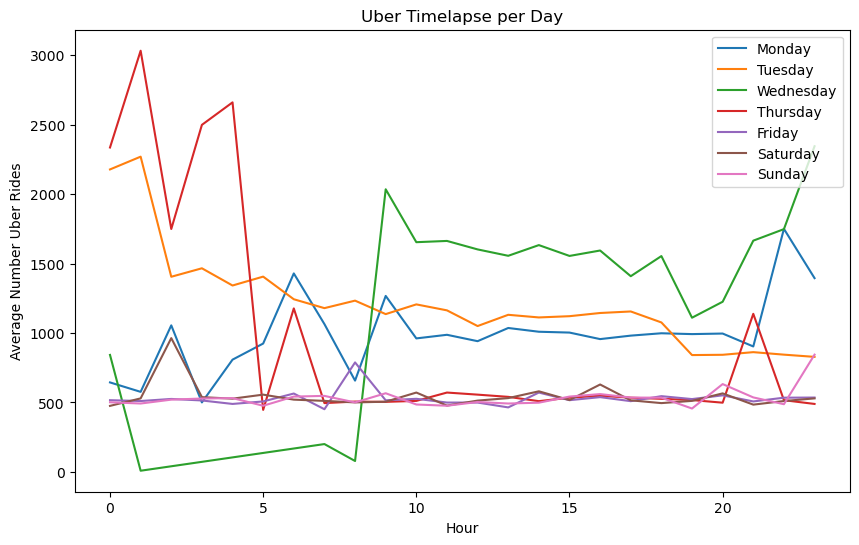

In [185]:
# Average Rides for Uber Timeseries
plot(mean_rides_uber)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Uber Rides')
plt.title("Uber Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.show()

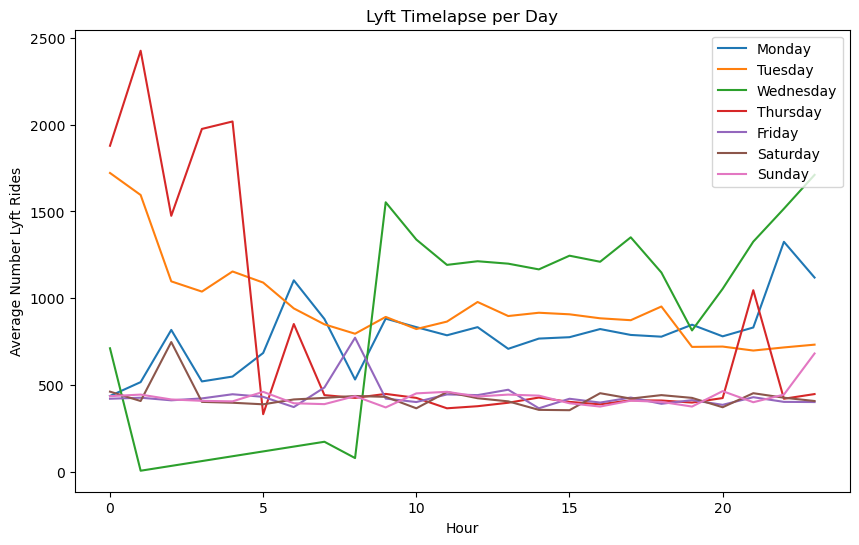

In [186]:
# Average Rides for Lyft Timeseries
plot(mean_rides_lyft)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Lyft Rides')
plt.title("Lyft Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.show()

## Part 3 - Rideshare Behavior vs Weather
----
#### Weather plays a pivotal role in commute! In our given data, there are plausible elements of nature that could potentially affect how one gets from point A to point B. Now that we have a general idea of what app is preferable, let's add a second layer to the analyses.

3.A How do factors like rain, wind speed and cloudiness affect one's preference to use Rideshare Apps? Is one app used more than the other? Is the frequency of rides affected with worse weather conditions?

In [187]:
# In order to better visualize the amount of rainfall, we need to convert our unit of measurement to millimeters and also derive count of rides per day

final_df["Rainfall(mm)"]=final_df["Rainfall(in)"]*25.4
final_df["Date by hour"]=final_df["Date"].dt.strftime("%Y-%m-%d %H:%M")

# Making a list of days in the given week. This will eventually be our x-axis
days_of_the_week=final_df["Date by hour"].unique()

# Splitting the edited dataframe by Rideshare App
uber_split = final_df.loc[final_df["Rideshare_App"]=="Uber"]
lyft_split = final_df.loc[final_df["Rideshare_App"]=="Lyft"]

In [188]:
# Finding out the count of rides taken per day of the week for Uber

uber_grouped=uber_split.groupby(["Date by hour"])
uber_ride_count=uber_grouped.count()["Destination"]
uber_ride_count.head()

Date by hour
2018-11-26 03:40    41
2018-11-26 04:40    52
2018-11-26 04:41    55
2018-11-26 04:43    50
2018-11-26 04:49    48
Name: Destination, dtype: int64

In [189]:
# Finding out the count of rides taken per day of the week for Uber

lyft_grouped=lyft_split.groupby(["Date by hour"])
lyft_ride_count=lyft_grouped.count()["Destination"]
lyft_ride_count.head()

Date by hour
2018-11-26 03:40    43
2018-11-26 04:40    32
2018-11-26 04:41    29
2018-11-26 04:43    34
2018-11-26 04:49    36
Name: Destination, dtype: int64

In [190]:
# Finding average rainfall each day

ave_rainfall=day_grouped.mean()["Rainfall(mm)"]
ave_rainfall.head()

/var/folders/33/k2j4j20s7fb5j52jx4p6qr0w0000gn/T/ipykernel_55836/3938839536.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ave_rainfall=day_grouped.mean()["Rainfall(mm)"]


Date by hour
2018-11-26 03:40    0.0
2018-11-26 04:40    0.0
2018-11-26 04:41    0.0
2018-11-26 04:43    0.0
2018-11-26 04:49    0.0
Name: Rainfall(mm), dtype: float64

In [191]:
# Finding average wind speed each day

ave_wind_speed=day_grouped.mean()["Wind_Speed(mph)"]
ave_wind_speed.head()

/var/folders/33/k2j4j20s7fb5j52jx4p6qr0w0000gn/T/ipykernel_55836/3025087932.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ave_wind_speed=day_grouped.mean()["Wind_Speed(mph)"]


Date by hour
2018-11-26 03:40    1.485952
2018-11-26 04:40    2.584048
2018-11-26 04:41    2.595238
2018-11-26 04:43    2.641310
2018-11-26 04:49    2.611190
Name: Wind_Speed(mph), dtype: float64

In [192]:
# Finding average wind speed each day

ave_cloudiness=day_grouped.mean()["Cloudiness(%)"]
ave_cloudiness.head()

/var/folders/33/k2j4j20s7fb5j52jx4p6qr0w0000gn/T/ipykernel_55836/3726979919.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ave_cloudiness=day_grouped.mean()["Cloudiness(%)"]


Date by hour
2018-11-26 03:40    87.309524
2018-11-26 04:40    86.452381
2018-11-26 04:41    86.428571
2018-11-26 04:43    85.892857
2018-11-26 04:49    94.511905
Name: Cloudiness(%), dtype: float64

In [193]:
# Create the final dataframe for plotting

rides_vs_weather = pd.DataFrame({"Uber Ride Count":uber_ride_count,"Lyft Ride Count":lyft_ride_count,"Average Rainfall (mm)":ave_rainfall,"Average Wind Speed (mph)":ave_wind_speed, "Average Cloudiness (%)":ave_cloudiness},index=days_of_the_week)
rides_vs_weather.head()

,Uber Ride Count,Lyft Ride Count,Average Rainfall (mm),Average Wind Speed (mph),Average Cloudiness (%)
2018-11-26 03:40,41.0,43.0,0.0,1.485952,87.309524
2018-11-26 04:40,52.0,32.0,0.0,2.584048,86.452381
2018-11-26 04:41,55.0,29.0,0.0,2.595238,86.428571
2018-11-26 04:43,50.0,34.0,0.0,2.641310,85.892857
2018-11-26 04:49,48.0,36.0,0.0,2.611190,94.511905


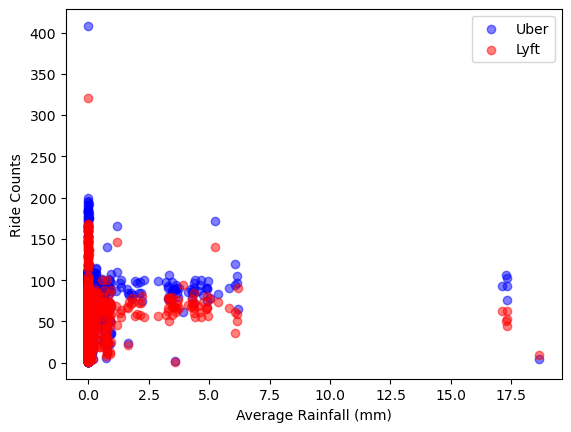

In [194]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Rainfall (mm)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Rainfall")
plt.show()

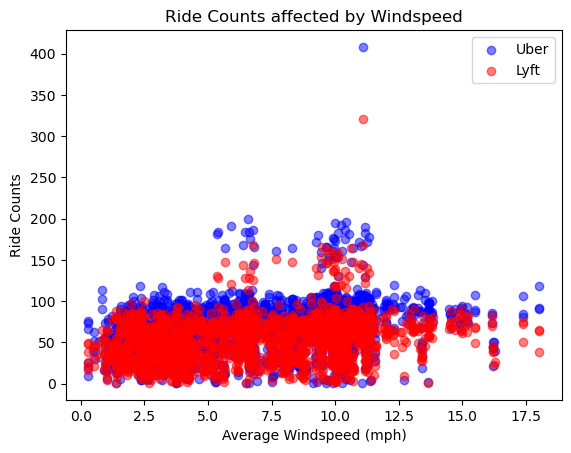

In [197]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Windspeed (mph)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Windspeed")
plt.show()

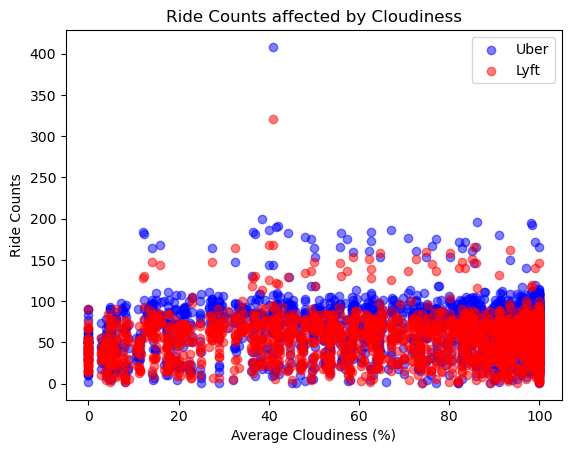

In [198]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Cloudiness (%)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Cloudiness")
plt.show()

In [199]:
final_df.head()

,Date,Weekday,Month,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph),Hour,Rainfall(mm),Date by hour
0,2018-11-26 03:40:46.318000128,Monday,11,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36,3,0.0,2018-11-26 03:40
1,2018-11-26 03:40:46.319000064,Monday,11,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55,3,0.0,2018-11-26 03:40
2,2018-11-26 03:40:46.319000064,Monday,11,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60,3,0.0,2018-11-26 03:40
3,2018-11-26 03:40:46.320000000,Monday,11,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55,3,0.0,2018-11-26 03:40
4,2018-11-26 03:40:46.320000000,Monday,11,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36,3,0.0,2018-11-26 03:40


In [200]:
#Pratik to add/develop necessary analysis

## Part 4 - Rideshare Behavior & Pricing
----
#### Next Part